In [1]:
import numpy as np 
import pandas as pd 
import json
#import bq_helper
from pandas.io.json import json_normalize
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import lightgbm as lgb

pd.set_option('display.max_columns', 100)


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.metrics import mean_squared_error

In [5]:
def load_df(csv_path='data/train.csv', JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource'],nrows=10000):

    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'},nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

    return df

In [6]:
%%time
train = load_df('data/train.csv')

CPU times: user 1.77 s, sys: 0 ns, total: 1.77 s
Wall time: 1.77 s


In [7]:
%%time
test = load_df('data/test.csv')

CPU times: user 1.7 s, sys: 8 ms, total: 1.7 s
Wall time: 1.97 s


In [8]:
#converting date to readable format 
train['date'] = pd.to_datetime(train['date'].apply(lambda x: str(x)[:4] + '-' + str(x)[4:6] + '-' + str(x)[6:]))
test['date'] = pd.to_datetime(test['date'].apply(lambda x: str(x)[:4] + '-' + str(x)[4:6] + '-' + str(x)[6:]))

#Analysis on missing values 

In [76]:
def checkMissingValue():
    count =0
    for col in train.columns:
        if train[col].isnull().sum() > 0:
            rate = train[col].isnull().sum() * 100 / train.shape[0]
            print(f'Column {col} has {rate:.4f}% missing values.')
            count +=1
        if train[col].dtype == 'object':
            if (train[col] == 'not available in demo dataset').sum() > 0:
                rate = (train[col] == 'not available in demo dataset').sum() * 100 / train.shape[0]
                print(f'Column {col} has {rate:.4f}% values not available in dataset.')
                count +=1
    print(f"There are {count} columns having missing value or not available in dataset")

In [77]:
checkMissingValue()

Column device.browserSize has 100.0000% values not available in dataset.
Column device.browserVersion has 100.0000% values not available in dataset.
Column device.flashVersion has 100.0000% values not available in dataset.
Column device.language has 100.0000% values not available in dataset.
Column device.mobileDeviceBranding has 100.0000% values not available in dataset.
Column device.mobileDeviceInfo has 100.0000% values not available in dataset.
Column device.mobileDeviceMarketingName has 100.0000% values not available in dataset.
Column device.mobileDeviceModel has 100.0000% values not available in dataset.
Column device.mobileInputSelector has 100.0000% values not available in dataset.
Column device.operatingSystemVersion has 100.0000% values not available in dataset.
Column device.screenColors has 100.0000% values not available in dataset.
Column device.screenResolution has 100.0000% values not available in dataset.
Column geoNetwork.city has 59.4100% values not available in data

# Handling missing values

In [37]:
# some data processing
train['trafficSource.adwordsClickInfo.isVideoAd'].fillna(True, inplace=True)
test['trafficSource.adwordsClickInfo.isVideoAd'].fillna(True, inplace=True)
train['trafficSource.isTrueDirect'].fillna(False, inplace=True)
test['trafficSource.isTrueDirect'].fillna(False, inplace=True)

In [39]:
#filling missing transactionRevenue by 0
train['totals.transactionRevenue'].fillna(0,inplace=True)

In [78]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 54 columns):
channelGrouping                                      10000 non-null object
date                                                 10000 non-null datetime64[ns]
fullVisitorId                                        10000 non-null object
sessionId                                            10000 non-null object
socialEngagementType                                 10000 non-null object
visitId                                              10000 non-null int64
visitNumber                                          10000 non-null float64
visitStartTime                                       10000 non-null int64
device.browser                                       10000 non-null object
device.browserSize                                   10000 non-null object
device.browserVersion                                10000 non-null object
device.deviceCategory                                10000 n

In [72]:
# converting columns into more reasonable format
for col in ['visitNumber', 'totals.hits', 'totals.pageviews', 'totals.transactionRevenue']:
    train[col] = train[col].astype(float)

# Visualization of transaction revenue

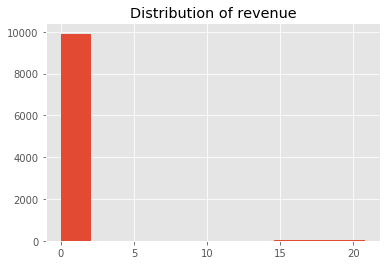

In [73]:
plt.hist(np.log1p(train.loc[train['totals.transactionRevenue'].isna() == False, 'totals.transactionRevenue']));
plt.title('Distribution of revenue');

# Total revenue per user

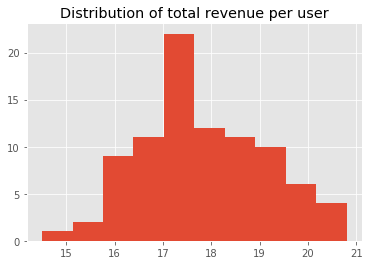

In [71]:
grouped = train.groupby('fullVisitorId')['totals.transactionRevenue'].sum().reset_index()
grouped = grouped.loc[grouped['totals.transactionRevenue'].isna() == False]
plt.hist(np.log(grouped.loc[grouped['totals.transactionRevenue'] > 0, 'totals.transactionRevenue']));
plt.title('Distribution of total revenue per user');

# Data analysis for transaction which has revenue

In [79]:
#converting transactionRevenue to its log

train['totals.transactionRevenue'] = np.log1p(train['totals.transactionRevenue'])


In [80]:
#taking only transaction who had revenue
train_ = train.loc[train['totals.transactionRevenue'] > 0.0]


In [81]:
#function to show count and mean aggregated by col for transactionRevenue
def show_count_sum(df, col):
    return df.groupby(col).agg({'totals.transactionRevenue': ['count', 'mean']}).sort_values(('totals.transactionRevenue', 'count'), ascending=False).head()


# geoNetwork

In [82]:
show_count_sum(train_, 'geoNetwork.subContinent')

totals.transactionRevenue           
                                            count       mean
geoNetwork.subContinent                                     
Northern America                               90  17.780558
Caribbean                                       1  16.810743

Most of the transaction is from Northern America. Lets dive into Northern America and see distribution about metro, networkDomain and region.

In [91]:
show_count_sum(train_.loc[train_['geoNetwork.subContinent'] == 'Northern America'], 'geoNetwork.metro')

totals.transactionRevenue           
                                                      count       mean
geoNetwork.metro                                                      
not available in demo dataset                            31  17.420974
San Francisco-Oakland-San Jose CA                        27  17.974056
New York NY                                              10  18.435341
Chicago IL                                                8  18.264101
Seattle-Tacoma WA                                         6  17.573569

In [92]:
show_count_sum(train_.loc[train_['geoNetwork.subContinent'] == 'Northern America'], 'geoNetwork.networkDomain')

totals.transactionRevenue           
                                             count       mean
geoNetwork.networkDomain                                     
(not set)                                       64  17.881140
comcast.net                                      8  17.825596
unknown.unknown                                  3  18.122527
comcastbusiness.net                              2  17.558785
rcn.com                                          2  16.728021

In [93]:
show_count_sum(train_.loc[train_['geoNetwork.subContinent'] == 'Northern America'], 'geoNetwork.region')

totals.transactionRevenue           
                                                  count       mean
geoNetwork.region                                                 
not available in demo dataset                        31  17.420974
California                                           29  17.878226
New York                                             10  18.435341
Illinois                                              8  18.264101
Washington                                            6  17.573569

Conclusion : Continent North America , with metro not available in dataset , with networkDomain (not set) with region not available in dataset have more revenue

# Traffic Source

In [83]:
show_count_sum(train_, 'trafficSource.medium')


totals.transactionRevenue           
                                         count       mean
trafficSource.medium                                     
referral                                    52  18.091034
organic                                     24  17.283712
(none)                                      12  17.345568
cpm                                          2  18.771761
cpc                                          1  15.827743

Most of the transaction is form referral